In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mu_data=np.load("../data/training_data/OrnsteinUhlenbeckMultiDimensional-68/data.npy")

In [12]:
mu_data.shape

(1000, 3, 101)

In [3]:
gen_data=np.load("../data/generated_data/data.npy")

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Compare (visualize) paths
def compare_path(x_real, x_fake, titles=["Real", "Fake"], file_path=None, return_figax=False, dim=0, plot_size=10):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4], sharex=True, sharey=True)
    ax[0].plot(
        x_real[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )
    ax[1].plot(
        x_fake[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )
    if titles:
        ax[0].set_title(titles[0])
        ax[1].set_title(titles[1])

    for i in range(2):
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Prices")
    if return_figax:
        return fig, ax
    if file_path is None:
        plt.show()
    else:
        plt.savefig(file_path, bbox_inches="tight")
    plt.close()

In [8]:
# Compare Marginal
def compare_marginal_hist(real_data, fake_data, n_time_slice=4, file_path=None):
    time_range = np.linspace(11, real_data.shape[1] - 1, n_time_slice, dtype=int)
    n_cols = n_time_slice
    fig, ax = plt.subplots(1, n_cols, figsize=[12, 4], sharey=True, sharex=True)
    bins = np.linspace(0, 5, 50)
    for i in range(n_cols):
        axi = ax.flat[i]
        n = time_range[i]
        axi.hist(real_data[:, n], bins=bins, alpha=0.5, label="real")
        axi.hist(fake_data[:, n], bins=bins, alpha=0.3, label="fake")
        axi.set_title(f"Time: {n}")
        axi.legend()
        # axi.set_xlabel("Marginal prices")
    if file_path is None:
        plt.show()
    else:
        plt.savefig(file_path, bbox_inches="tight")
        plt.close(fig)

In [9]:
# Compare Drift and Volatility
def prices2returns(prices):
    returns = prices[:, 1:] / prices[:, :-1] - 1
    return returns


def compute_volatility(price_path, T):
    return_path = prices2returns(price_path)
    vol2 = torch.sum(return_path**2, dim=1) / T
    vol = torch.sqrt(vol2)
    return vol


def compute_drift(price_path, T):
    return_path = prices2returns(price_path)
    drift = torch.sum(return_path, dim=1) / T
    return drift


def plot_mean_log_prices(data, data_name, axi):
    data = torch.log(data)
    data_mean = torch.mean(data, dim=0)
    data_std = torch.std(data, dim=0)
    axi.plot(data_mean, marker="o", linewidth=1, markersize=1, label=data_name)
    axi.fill_between(
        torch.arange(len(data_mean)),
        data_mean - data_std,
        data_mean + data_std,
        alpha=0.2,
    )


def compare_drift_volatility(real_data, fake_data, T):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4])

    plot_mean_log_prices(real_data, "real", ax[0])
    plot_mean_log_prices(fake_data, "fake", ax[0])
    ax[0].legend()
    ax[0].set_xlabel("Time")
    ax[0].set_title("Log-prices")

    vol = compute_volatility(real_data, T)
    ax[1].hist(vol, bins=100, alpha=0.4, label="real", density=True)
    # sns.kdeplot(vol,ax = ax[1])
    vol = compute_volatility(fake_data, T)
    ax[1].hist(vol, bins=100, alpha=0.4, label="fake", density=True)
    # sns.kdeplot(vol,ax = ax[1])
    ax[1].legend()
    ax[1].set_title("Volatility")
    ax[1].set_xlabel("Volatility")
    plt.show()

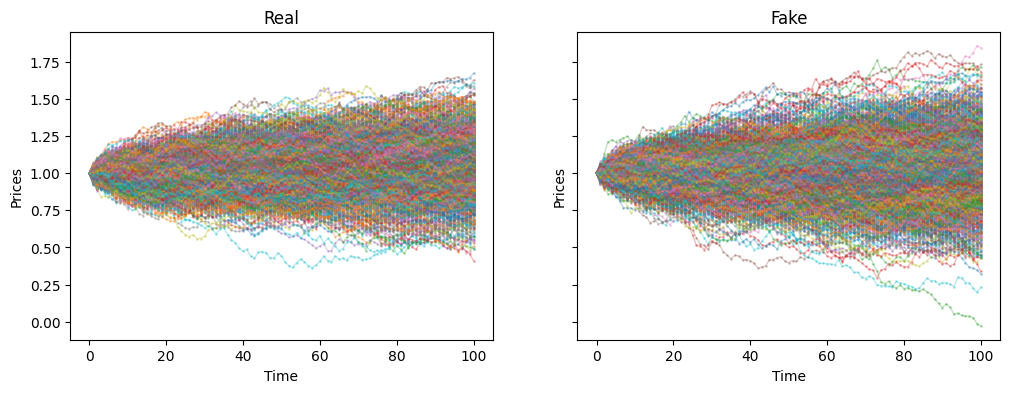

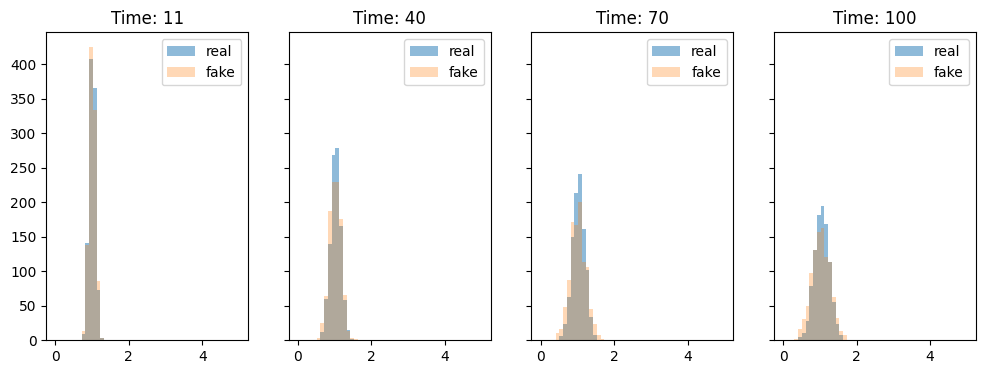

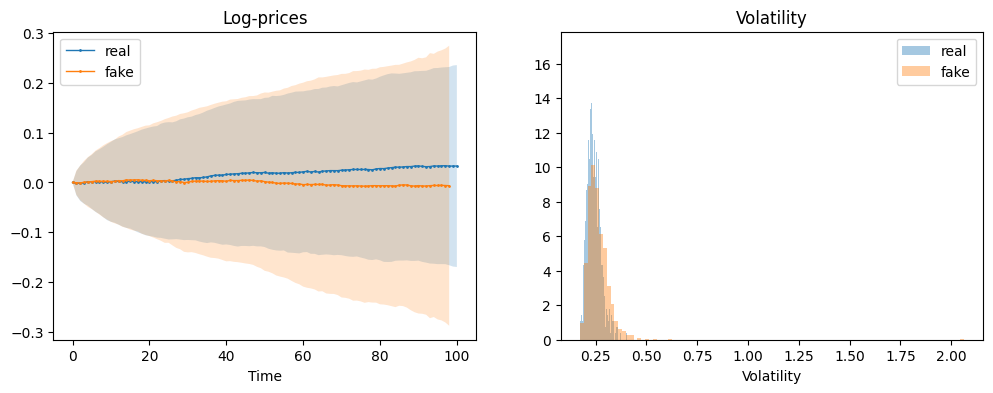

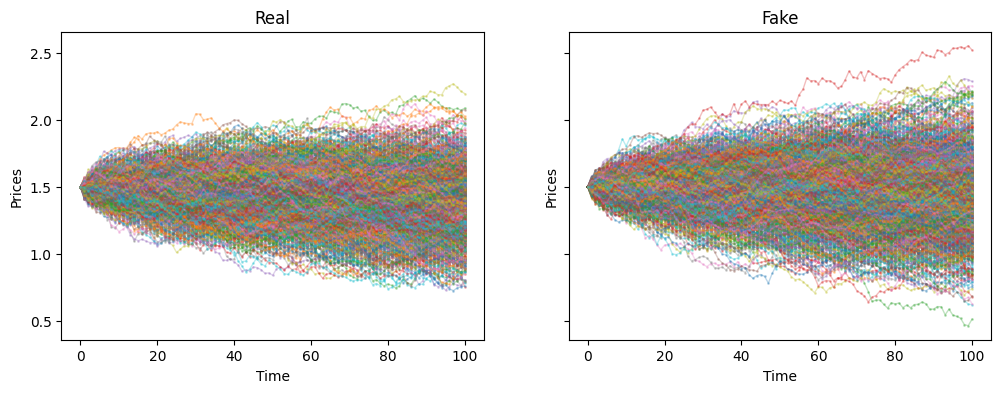

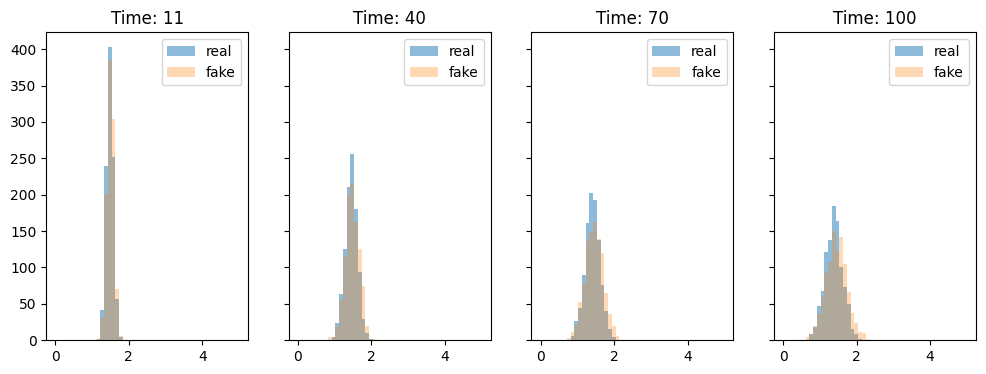

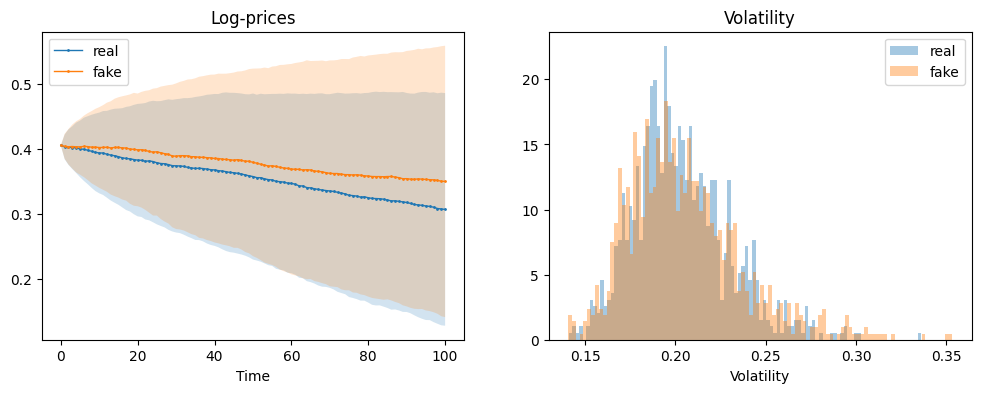

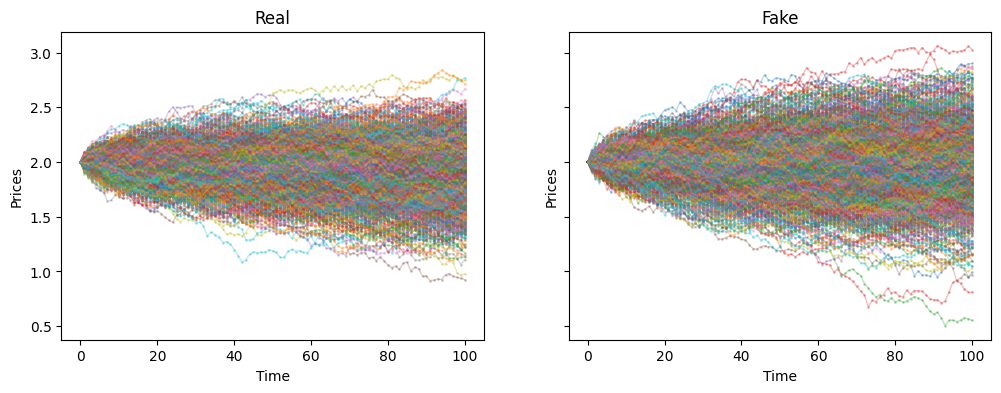

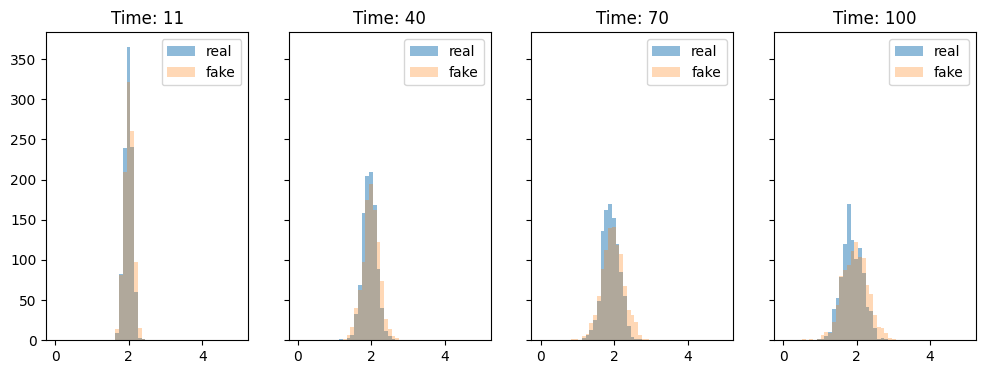

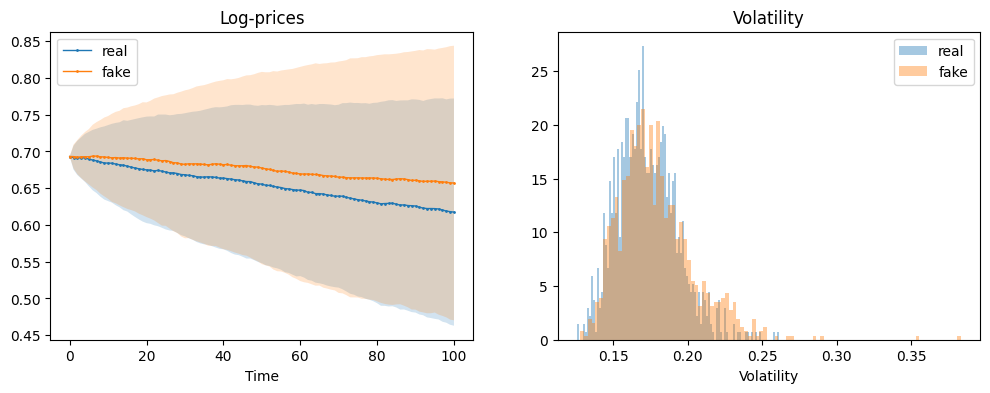

In [10]:
for i in range(3):
    real_data = torch.tensor(mu_data[:, i, :])
    fake_data = torch.tensor(gen_data[:,i,:])
    compare_path(real_data, fake_data, plot_size=1000)
    compare_marginal_hist(real_data,fake_data , 4)
    compare_drift_volatility(real_data,fake_data, 1)

In [17]:
def find(x):
    s_x = np.sum(x[:-1])
    s_y = np.sum(x[1:])
    s_xx = np.sum(x[:-1]**2)
    s_yy = np.sum(x[1:]**2)
    s_xy = np.sum(x[:-1] * x[1:])
    n = len(x)-1
    delta = 0.01

    mu = ((s_y*s_xx)-(s_x*s_xy))/(n*(s_xx-s_xy)-((s_x**2)-s_x*s_y)) # Mean

    theta = -(1/delta)*np.log((s_xy-mu*s_x-mu*s_y+n*mu**2)/(s_xx-2*mu*s_x+n*mu**2)) # Rate

    alpha = np.exp(-theta*delta)
    sigma_h = np.sqrt((1/n)*(s_yy-(2*alpha*s_xy)+((alpha**2)*s_xx)-(2*mu*(1-alpha)*(s_y-alpha*s_x))+(n*(mu**2)*(1-alpha)**2)))

    sigma = np.sqrt((sigma_h**2)*(2*theta/(1-alpha**2))) #Volatility

    return mu, sigma, theta

In [14]:
def estimate_params(x):
    mu=[]
    sigma=[]
    theta=[]
    for i in range(x.shape[0]):
        a,b,c=find(x[i,:])
        mu.append(a)
        sigma.append(b)
        theta.append(c) 
    return np.mean(mu), np.std(mu), np.mean(sigma), np.std(sigma), np.mean(theta),np.std(theta) 

In [16]:
for i in range(3):
    real_data = mu_data[:, i, :]
    fake_data = gen_data[:, i, :]

    # Estimate parameters for real data
    mu_real, mu_std_real, sigma_real, sigma_std_real, theta_real, theta_std_real = estimate_params(real_data)
    print(f"Estimated parameters for real paths (dimension {i+1}):")
    print(f"  Mean (mu): {mu_real:.4f} ± {mu_std_real:.4f}")
    print(f"  Volatility (sigma): {sigma_real:.4f} ± {sigma_std_real:.4f}")
    print(f"  Mean reversion rate (theta): {theta_real:.4f} ± {theta_std_real:.4f}")

    # Estimate parameters for generated data
    mu_fake, mu_std_fake, sigma_fake, sigma_std_fake, theta_fake, theta_std_fake = estimate_params(fake_data)
    print(f"Estimated parameters for generated paths (dimension {i+1}):")
    print(f"  Mean (mu): {mu_fake:.4f} ± {mu_std_fake:.4f}")
    print(f"  Volatility (sigma): {sigma_fake:.4f} ± {sigma_std_fake:.4f}")
    print(f"  Mean reversion rate (theta): {theta_fake:.4f} ± {theta_std_fake:.4f}")
    print()  # Add a newline for better readability between dimensions

Estimated parameters for real paths (dimension 1):
  Mean (mu): 1.0612 ± 0.8379
  Volatility (sigma): 0.2465 ± 0.0180
  Mean reversion rate (theta): 5.9081 ± 4.7993
Estimated parameters for generated paths (dimension 1):
  Mean (mu): 0.9563 ± 3.1608
  Volatility (sigma): 0.2568 ± 0.0206
  Mean reversion rate (theta): 5.6461 ± 4.8051

Estimated parameters for real paths (dimension 2):
  Mean (mu): 1.6220 ± 4.9678
  Volatility (sigma): 0.2893 ± 0.0204
  Mean reversion rate (theta): 5.8184 ± 4.9516
Estimated parameters for generated paths (dimension 2):
  Mean (mu): -0.7381 ± 72.5643
  Volatility (sigma): 0.2968 ± 0.0237
  Mean reversion rate (theta): 5.5163 ± 4.7006

Estimated parameters for real paths (dimension 3):
  Mean (mu): 2.0644 ± 6.1241
  Volatility (sigma): 0.3330 ± 0.0246
  Mean reversion rate (theta): 5.6271 ± 5.0272
Estimated parameters for generated paths (dimension 3):
  Mean (mu): 1.5606 ± 13.7895
  Volatility (sigma): 0.3499 ± 0.0278
  Mean reversion rate (theta): 5.5877

In [19]:
from scipy.stats import norm 
from scipy.optimize import minimize

def OU(x1, x2, dt, theta, mu, sigma):
    sigma0=sigma**2*(1-np.exp(-2*mu*dt))/(2*mu)
    sigma0=np.sqrt(sigma0)
    
    prefactor = 1/np.sqrt(2*np.pi*sigma0**2)
    
    f = prefactor*np.exp(-(x2-x1*np.exp(-mu*dt)-theta*(1-np.exp(-mu*dt)))**2/(2*sigma0**2))
    
    return f 

def log_likelihood_OU(p,X,dt):
    theta=p[0]
    mu=p[1]
    sigma=p[2]
    
    N=X.size
    
    f = np.zeros((N-1,))
    
    for i in range(1, N):
        x2=X[i]
        x1=X[i-1]
        
        f[i-1]=OU(x1,x2, dt, theta, mu, sigma)
        
    ind= np.where(f==0)
    ind=ind[0]
    if ind.size>0:
        f[ind]=10**-8
    f=np.log(f)
    f=np.sum(f)
    
    return -f 

def constraint1(p):
    return p[1]

def constraint2(p):
    return p[2]

In [21]:
cons = ({"type":"ineq", "fun":constraint1},
        {"type":"ineq", "fun":constraint2})

p0 = [0.25, 1, 0.25]

minimize(log_likelihood_OU, p0, args=(calculate_returns(mu_data)[:,0], 0.01), constraints=cons)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -244008.16909647302
       x: [-1.804e-04  3.108e+04  5.258e+00]
     nit: 46
     jac: [ 2.560e+01  1.953e-03  1.953e-01]
    nfev: 238
    njev: 46

In [28]:
minimize(log_likelihood_OU, p0, args=(calculate_returns(gen_data)[:,0], 0.01), constraints=cons)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -238869.91735439474
       x: [-9.416e-05  4.809e+04  6.883e+00]
     nit: 46
     jac: [ 1.699e-01  0.000e+00  3.906e-03]
    nfev: 235
    njev: 44

In [29]:
minimize(log_likelihood_OU, p0, args=(calculate_returns(gen_data)[:,1], 0.01), constraints=cons)

C:\Users\gg868\AppData\Local\Temp\ipykernel_8996\1644050908.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  prefactor = 1/np.sqrt(2*np.pi*sigma0**2)
C:\Users\gg868\AppData\Local\Temp\ipykernel_8996\1644050908.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  f = prefactor*np.exp(-(x2-x1*np.exp(-mu*dt)-theta*(1-np.exp(-mu*dt)))**2/(2*sigma0**2))
C:\Users\gg868\AppData\Local\Temp\ipykernel_8996\1644050908.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  f = prefactor*np.exp(-(x2-x1*np.exp(-mu*dt)-theta*(1-np.exp(-mu*dt)))**2/(2*sigma0**2))


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1842049.6537144931
       x: [ 1.391e-04  6.565e+04 -7.192e-09]
     nit: 41
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 210
    njev: 41

In [30]:
minimize(log_likelihood_OU, p0, args=(calculate_returns(mu_data)[:,1], 0.01), constraints=cons)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -243833.40183545538
       x: [-2.674e-04  4.508e+04  6.343e+00]
     nit: 51
     jac: [ 5.385e+00  3.906e-03  0.000e+00]
    nfev: 260
    njev: 51

In [31]:
minimize(log_likelihood_OU, p0, args=(calculate_returns(mu_data)[:,2], 0.01), constraints=cons)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1842049.6537144931
       x: [-2.420e+03  2.470e+04  1.018e+01]
     nit: 25
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 131
    njev: 24

In [33]:
minimize(log_likelihood_OU, p0, args=(calculate_returns(gen_data)[:,2], 0.01), constraints=cons)["x"]

array([-6.41211441e-05,  7.92539029e+04,  8.80943887e+00])

In [22]:
def calculate_returns(prices, return_type='simple'):
    """
    Calculate and combine returns from a price dataset.

    Parameters:
    prices (np.array): Input array with shape (n_paths, dim, time-steps)
    return_type (str): Type of returns to calculate ('log' or 'simple')

    Returns:
    np.array: Combined returns with shape (n_paths * (time-steps - 1), dim)
    """
    if return_type not in ['log', 'simple']:
        raise ValueError("return_type must be either 'log' or 'simple'")

    if return_type == 'log':
        log_prices = np.log(prices)
        returns = np.diff(log_prices, axis=2)
    else:  # return_type == 'simple'
        returns = np.diff(prices, axis=2) / prices[:, :, :-1]

    dim = returns.shape[1]
    combined_returns = returns.reshape(-1, dim)

    return combined_returns

In [27]:
for i in range(3):
    a=find(calculate_returns(mu_data)[:,i])
    print(a)
    b=find(calculate_returns(gen_data)[:,i])
    print(b)

(-0.00018050756609663243, nan, nan)
(-8.339284897861357e-05, nan, nan)
(-0.00026744682851182454, nan, nan)
(-9.247058291877919e-05, 0.8041116945931309, 660.4164779675714)
(-0.00029953490450311467, nan, nan)
(-7.710539759026484e-05, 0.8173740339102709, 652.1724877955792)


C:\Users\gg868\AppData\Local\Temp\ipykernel_8996\4039375173.py:12: RuntimeWarning: invalid value encountered in log
  theta = -(1/delta)*np.log((s_xy-mu*s_x-mu*s_y+n*mu**2)/(s_xx-2*mu*s_x+n*mu**2)) # Rate


In [23]:
find(calculate_returns(mu_data)[:,0])

C:\Users\gg868\AppData\Local\Temp\ipykernel_8996\4039375173.py:12: RuntimeWarning: invalid value encountered in log
  theta = -(1/delta)*np.log((s_xy-mu*s_x-mu*s_y+n*mu**2)/(s_xx-2*mu*s_x+n*mu**2)) # Rate


(-0.00018050756609663243, nan, nan)

In [25]:
find(calculate_returns(gen_data)[:,0])

C:\Users\gg868\AppData\Local\Temp\ipykernel_8996\4039375173.py:12: RuntimeWarning: invalid value encountered in log
  theta = -(1/delta)*np.log((s_xy-mu*s_x-mu*s_y+n*mu**2)/(s_xx-2*mu*s_x+n*mu**2)) # Rate


(-8.339284897861357e-05, nan, nan)

In [ ]:
f

In [52]:
import scipy.linalg as la 

def estimate_ou_params(paths, dt=0.01): 
    
    n_paths, dim, time_steps = paths.shape 
    
    dX=np.diff(paths, axis=2)
    X= paths[:,:,:-1]
    
    X_flat  = X.transpose(0,2,1).reshape(-1,dim)
    dX_flat = dX.transpose(0,2,1).reshape(-1,dim)
    N=X_flat.shape[0]
    
    ones=np.ones((N,1))
    Z=np.hstack([X_flat,ones])
    W, *_ =np.linalg.lstsq(Z,dX_flat,rcond=None)
    
    C=W[:dim,:]
    v=W[dim,:]
    
    theta = -(1.0/dt)*C.T
    mu = la.solve(theta,v/dt)
    
    resid = dX_flat - Z.dot(W) 
    Q_eps = np.cov(resid, rowvar=False)
    Q_hat = Q_eps/dt 
    
    jitter = 1e-8*np.eye(dim)
    sigma = la.cholesky(Q_hat+jitter, lower = True)
    
    return theta, mu, Q_hat 

In [53]:
estimate_ou_params(mu_data)

(array([[ 0.35596852,  0.05074321,  0.02935922],
        [ 0.17379613,  0.29419029, -0.01321412],
        [ 0.00414911,  0.07360407,  0.30964166]]),
 array([1.28317376, 0.87080603, 1.66756841]),
 array([[0.05980565, 0.05494058, 0.05964902],
        [0.05494058, 0.0824685 , 0.06480941],
        [0.05964902, 0.06480941, 0.10945496]]))

In [54]:
estimate_ou_params(gen_data)

(array([[ 0.15511637,  0.0815901 , -0.16761926],
        [ 0.0856735 ,  0.02667916, -0.03660477],
        [-0.05320016,  0.15307011, -0.04701539]]),
 array([0.09313843, 0.43425569, 0.45558407]),
 array([[0.06539633, 0.06017071, 0.06766915],
        [0.06017071, 0.0873966 , 0.07273339],
        [0.06766915, 0.07273339, 0.12149644]]))

In [5]:
import numpy as np
from scipy.linalg import logm, sqrtm

def estimate_ou_params(X, dt=0.01):
    """
    Estimate parameters of a 3-D OU process from data.

    Parameters
    ----------
    X : array_like, shape (N, 3)
        Observations X[0], X[1], ..., X[N-1].
    dt : float
        Sampling interval Δt.

    Returns
    -------
    Theta : ndarray, shape (3,3)
        Estimated mean-reversion rate matrix.
    mu : ndarray, shape (3,)
        Estimated long-term mean.
    Sigma : ndarray, shape (3,3)
        Approximate diffusion volatility matrix.
    """
    X = np.asarray(X)
    N, d = X.shape
    if d != 3:
        raise ValueError("This routine assumes 3-dimensional data.")

    # Build regression: X1 = A · [X0; 1] + resid
    X0 = X[:-1]          # shape (N-1, 3)
    X1 = X[1:]           # shape (N-1, 3)
    A  = np.hstack([X0, np.ones((N-1,1))])  # (N-1, 4)

    # Solve least-squares: A @ B = X1  ⇒  B shape (4,3)
    B, *_ = np.linalg.lstsq(A, X1, rcond=None)

    C  = B[:3, :].T     # discrete‐time coefficient matrix (3×3)
    c0 = B[ 3, : ]      # intercept vector length 3

    # Continuous‐time parameters
    Theta = -logm(C) / dt        # mean‐reversion
    mu    = np.linalg.solve(np.eye(3) - C, c0)  # long‐term mean

    # Residuals & diffusion
    resid = X1 - (X0.dot(C.T) + c0)   # (N-1,3)
    Q     = np.cov(resid.T, bias=True)  # E[ε εᵀ]
    # For small dt, ΣΣᵀ ≈ Q/dt
    Sigma = sqrtm(Q / dt)

    return Theta.real, mu.real, Sigma.real

In [6]:
estimate_ou_params(mu_data[0,:,:].T)

(array([[ 9.10484745, -5.02661703, -0.10245647],
        [ 0.74317213,  8.24005459, -3.9794665 ],
        [10.00411368, -9.41947913,  4.95050739]]),
 array([1.17782003, 1.55933844, 1.7395388 ]),
 array([[0.19845422, 0.09164714, 0.10746152],
        [0.09164714, 0.23687727, 0.09870168],
        [0.10746152, 0.09870168, 0.29177329]]))

In [7]:
estimate_ou_params(mu_data[1,:,:].T)

(array([[ 22.31663844, -12.34070206,   3.97886088],
        [ 11.46982652,  -6.98356032,   2.30343257],
        [ 11.93237063, -11.93983851,   6.0650238 ]]),
 array([1.35371888, 2.87775172, 3.65314226]),
 array([[0.18983518, 0.09580403, 0.09962268],
        [0.09580403, 0.25130966, 0.09374265],
        [0.09962268, 0.09374265, 0.28508389]]))

In [10]:
import numpy as np
from scipy.linalg import logm, expm
from numpy.linalg import inv


def estimate_ou_params_multivariate(X, dt):
    """
    Estimate parameters of a d-dimensional OU process from a single path.

    Args:
        X (np.ndarray): Array of shape (N, d), observed states at discrete times.
        dt (float): Time step size.

    Returns:
        Kappa_hat (np.ndarray): Estimated drift matrix (d x d).
        Theta_hat (np.ndarray): Estimated long-term mean vector (d,).
        Sigma_hat (np.ndarray): Estimated diffusion matrix (d x d) (Cholesky factor).
    """
    N, d = X.shape

    # Form data matrices: previous and next observations
    X_prev = X[:-1]         # shape (N-1, d)
    X_next = X[1:]          # shape (N-1, d)

    # Design matrix with intercept
    Z = np.hstack([X_prev, np.ones((N-1, 1))])  # shape (N-1, d+1)

    # Multivariate OLS: solve Z @ coefs = X_next
    coefs, *_ = np.linalg.lstsq(Z, X_next, rcond=None)
    # Partition coefficients
    beta_hat = coefs[:-1].T   # (d x d) autoregression matrix
    alpha_hat = coefs[-1]     # (d,) intercept vector

    # Estimate phi and intercept in X_{t+1} = phi X_t + c + noise
    phi_hat = beta_hat
    c_hat = alpha_hat

    # Drift matrix estimation
    Kappa_hat = -logm(phi_hat) / dt

    # Long-run mean estimation
    Theta_hat = inv(np.eye(d) - phi_hat) @ c_hat

    # Residuals
    residuals = X_next - X_prev.dot(phi_hat.T) - c_hat
    # Sample residual covariance
    V_hat = residuals.T @ residuals / (N - 1)

    # Solve for Q = Sigma Sigma^T using vectorization:
    # vec(V_hat) = ( \int_0^dt exp(-A s) Q exp(-A^T s) ds )vec = K vec(Q)
    M = np.kron(-Kappa_hat, np.eye(d)) + np.kron(np.eye(d), -Kappa_hat)
    K_mat = np.linalg.inv(M) @ (np.eye(d*d) - expm(-M * dt))
    vec_Q = np.linalg.solve(K_mat, V_hat.flatten())
    Q_hat = vec_Q.reshape((d, d))
    # Symmetrize
    Q_hat = (Q_hat + Q_hat.T) / 2

    # Cholesky factor as diffusion estimate
    Sigma_hat = np.linalg.cholesky(Q_hat)

    return Kappa_hat, Theta_hat, Sigma_hat


In [11]:
estimate_ou_params_multivariate(mu_data[0,:,:].T,0.01)

(array([[ 9.10484745, -5.02661703, -0.10245647],
        [ 0.74317213,  8.24005459, -3.9794665 ],
        [10.00411368, -9.41947913,  4.95050739]]),
 array([1.17782003, 1.55933844, 1.7395388 ]),
 array([[0.23788694, 0.        , 0.        ],
        [0.20606233, 0.16692149, 0.        ],
        [0.24592539, 0.06035745, 0.19199591]]))

In [36]:
import matplotlib.pyplot as plt

def compare_paths(real_data, fake_data, out_path="3D_OU.png"):
    # Use a clean Seaborn-inspired style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Figure with shared x-axis
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # Pick a qualitative color palette
    colors = plt.get_cmap('tab10').colors
    lw = 2  # line width

    for dim in range(3):
        real_path = real_data[:, dim, :]
        fake_path = fake_data[:, dim, :]

        # Plot fake paths (dashed) and real paths (solid)
        for run in range(5):
            axs[dim].plot(
                fake_path[run, :],
                linestyle='--',
                color=colors[run % len(colors)],
                label= "Fake"
            )
            axs[dim].plot(
                real_path[run, :],
                color=colors[run % len(colors)],
                label= "Real"
            )

        axs[dim].set_title(f"Dimension {dim+1}", fontsize=12, pad=8)
        axs[dim].set_ylabel("Price", fontsize=10)
        axs[dim].grid(True, which='both', linestyle=':', alpha=0.6)

    # Common X label
    axs[-1].set_xlabel("Time step", fontsize=10)

    # Single legend at top center
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, ["Fake", "Real"], loc="lower right", ncol=2, frameon=False, fontsize=11)

    # Super-title
    fig.suptitle("Real and Fake Sample Paths for 3D Ornstein-Uhlenbeck Process", fontsize=14, y=0.96)

    # Tight layout and save high-res PNG
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    fig.savefig(out_path, dpi=300)
    plt.show()

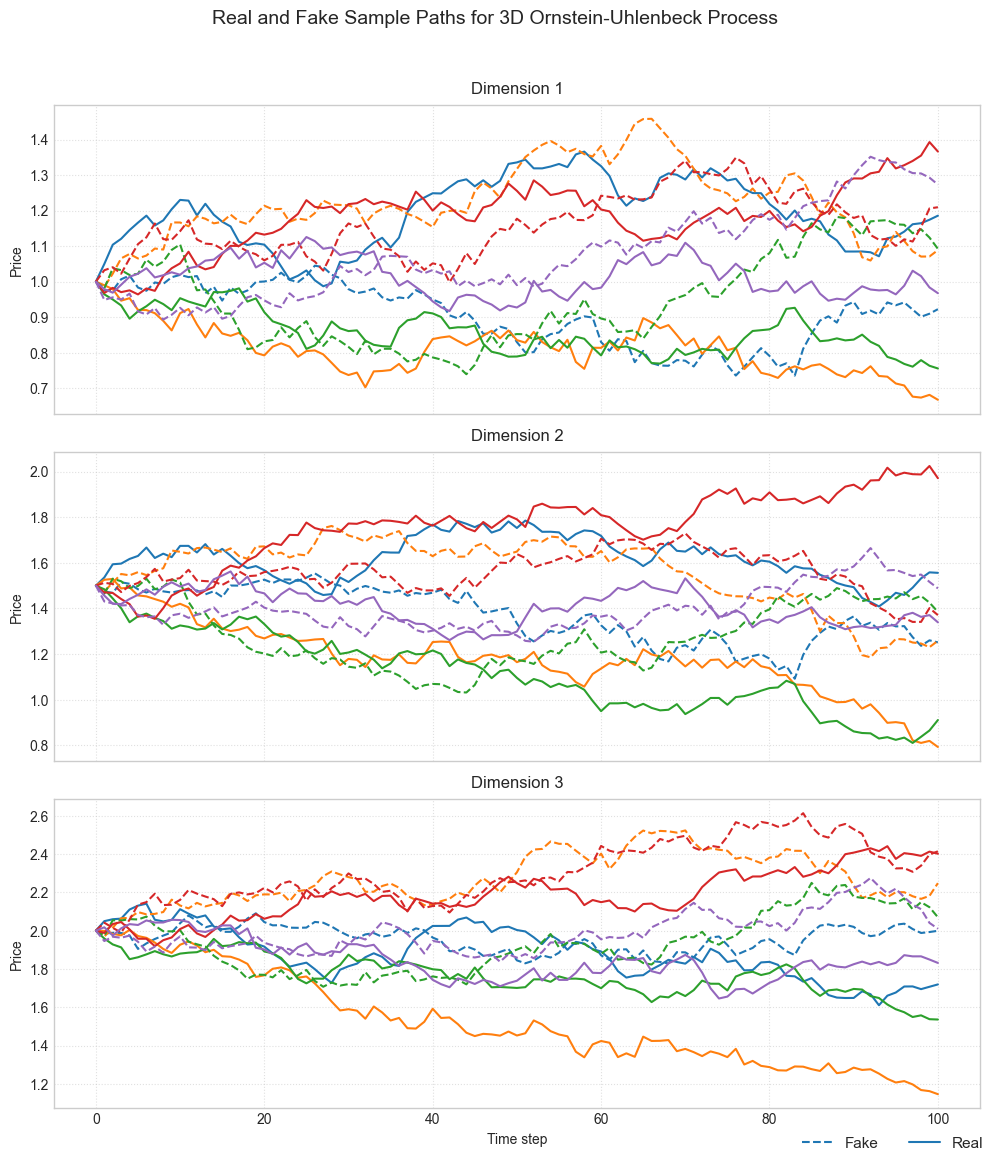

In [37]:
compare_paths(mu_data,gen_data)